# Lecture Summary

## Wider vs Deeper
 
DeepNetwork에서 hidden layer의 사이즈를 넓힐 것이냐, Layer 깊이를 깊게 할 것이냐의 이슈가 있음. 그러나 parameter 복잡도나, feature 가 생기는 단계의 직관적 측면에서 deep 하게 layer를 가져가는게 나음
![deep](images/L3-deep-a.png)
![deep](images/L3-deep-b.png)

## Regularization

Deep Network는 굉장히 overfitting이 쉽게 일어나서, regularization이 반드시 필요.  
![deep](images/L3-Reg-a.png)
### (a) L2 Regularization
아래와 같이 일반적으로 L2 regularization 을 사용
![deep](images/L3-Reg-b.png)
regularization term이 미분하면 w가 되는 특성을 가짐
![deep](images/L3-Reg-bb.png)

스키니 진과 같은 역할
![deep](images/L3-Reg-c.png)

### (b) Dropout

랜덤하게 결과 일부를 누락시켜서 평균을 이용하는 방법인데, 정확히 효과나 원리는 잘 모르겠음.

![dropout](images/L3-reg-drop-a.png)
![dropout](images/L3-reg-drop-b.png)
![dropout](images/L3-reg-drop-c.png)

---
# Assignment 3

regularization에 대해서 진행하도록 하겠다.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib inline

/Users/Josh/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as  f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save # hint to help gc free up memory
    print ('Training set', train_dataset.shape, train_labels.shape)
    print ('Validation set', valid_dataset.shape, valid_labels.shape)
    print ('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to trian:
- data as a flat matrix
- labels as float 1-hot encodings

In [3]:
image_size = 28
num_labels = 10

def reformat (dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size )).astype(np.float32)
    # 1-hot encoding (e.g. Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...])
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print ('Training set', train_dataset.shape, train_labels.shape)
print ('Validataion set', valid_dataset.shape, valid_labels.shape)
print ('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validataion set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels,1))/predictions.shape[0] )

# Problem 1

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compue the L2 loss for a tensor t using nn.l2_loss(t). The right amount of regularization should improve your validation / test accuracy.

[Reference](https://github.com/Arn-O/udacity-deep-learning/blob/master/3_regularization.ipynb)

## Logistic Regression with L2 Loss Function

conrtucting graph:

In [5]:
batch_size = 128

graph  = tf.Graph()

with graph.as_default():
    # Input data
    # For the training data, use placeholder that will be fed at run time with a training minibatch. 
    tf_train_dataset = tf.placeholder(tf.float32, shape =(batch_size, image_size * image_size) )
    tf_train_labels = tf.placeholder(tf.float32, shape =(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation 
    # Regularization applied !!
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
    beta_regul * tf.nn.l2_loss(weights)
    
    #Optimizer
    optimizer = tf.train.GradientDescentOptimizer(.5).minimize(loss)
    
    #predictions for the training, validation and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Executing: 

In [6]:
num_steps = 3001

with tf.Session(graph = graph ) as sess:
    tf.initialize_all_variables().run()
    print("Initialized.")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomnized.
        # Note: we could use better randomnized across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # prepare a dic telling the session where to feed the minibatch
        # the key of the dictionary : the placeholder node of the graph to be fed, 
        # the value : numpy array to feed to it
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul: 1e-3}
        _, l, predictions = sess.run([optimizer, loss, train_prediction], feed_dict = feed_dict)

        if (step % 500 == 0 ):
            print ("===  MiniBatch Loss at step %d: %f" % (step, l) )
            print ("MiniBatch Accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print ("Validation Accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels) )

    print ("Test Accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels) )       

Initialized.
===  MiniBatch Loss at step 0: 24.382122
MiniBatch Accuracy: 1.6%
Validation Accuracy: 15.4%
===  MiniBatch Loss at step 500: 2.055788
MiniBatch Accuracy: 96.9%
Validation Accuracy: 21.1%
===  MiniBatch Loss at step 1000: 1.252757
MiniBatch Accuracy: 96.1%
Validation Accuracy: 17.8%
===  MiniBatch Loss at step 1500: 0.783893
MiniBatch Accuracy: 96.9%
Validation Accuracy: 14.5%
===  MiniBatch Loss at step 2000: 0.521353
MiniBatch Accuracy: 97.7%
Validation Accuracy: 14.8%
===  MiniBatch Loss at step 2500: 1.115992
MiniBatch Accuracy: 91.4%
Validation Accuracy: 15.1%
===  MiniBatch Loss at step 3000: 0.642860
MiniBatch Accuracy: 93.8%
Validation Accuracy: 13.6%
Test Accuracy: 14.2%


: **Finding Best regularization Value **

In [7]:
num_steps = 3001
regul_val = [pow(10,i) for i in np.arange(-4,-2,.1)]
accuracy_val = []

for regul in regul_val: 
    with tf.Session(graph = graph) as sess:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            # pick an offset within training data, which has been randomnized
            # Note: we could use better randomnized across epochs
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            
            # Generate a minibatch
            batch_data = train_dataset[offset:(offset + batch_size), : ]
            batch_labels = train_labels[offset:(offset + batch_size), : ]
            
            #prepare feed_dict
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul: regul}
            _, l, predictions = sess.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

(20,) (20,)


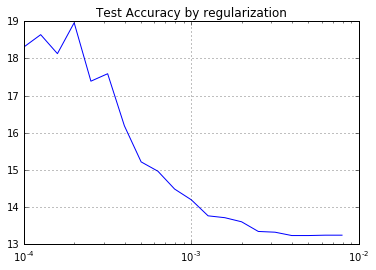

In [8]:
print (np.shape(regul_val), np.shape(accuracy_val))

plt.semilogx(regul_val, accuracy_val)
plt.grid(True); plt.title("Test Accuracy by regularization"); plt.show()

## 1-layer Neural Network with L2 Regualrization

** :Contruct **

In [9]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()

with graph.as_default():
    # Input data (Constants, Placeholder)
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset =tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1= tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training Computation
    layer1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(layer1_train, weights2) + biases2
    
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) +\
                beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data
    train_prediction = tf.nn.softmax(logits)

    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(layer1_valid, weights2) + biases2)
    
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)    

** : Execute **

In [10]:
if False: 
    print (train_labels.shape[0] - batch_size)
    print ((128 * 2000) % (train_labels.shape[0] - batch_size))

In [11]:
num_steps =3001

with tf.Session(graph = graph) as sess:
    tf.initialize_all_variables().run(); print ("Initialized")
    for step in range(num_steps):
        # pick an offset within the training data, which has been randomnized
        # Note: we could use better randomnization across epochs
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch 
        batch_data = train_dataset[offset: (offset+ batch_size), :]
        batch_labels = train_labels[offset: (offset+ batch_size), :]
        
        # Prepare feed_dict
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul: 1e-3}
        _, l, predictions = sess.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 500 ==0 ):
            print ("==MiniBatch loss at step %d: %f" %(step, 1))
            print ("MiniBatch Accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print ("Validation Accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print ("Test Accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    

Initialized
==MiniBatch loss at step 0: 1.000000
MiniBatch Accuracy: 18.0%
Validation Accuracy: 10.0%
==MiniBatch loss at step 500: 1.000000
MiniBatch Accuracy: 100.0%
Validation Accuracy: 12.0%
==MiniBatch loss at step 1000: 1.000000
MiniBatch Accuracy: 99.2%
Validation Accuracy: 19.1%
==MiniBatch loss at step 1500: 1.000000
MiniBatch Accuracy: 100.0%
Validation Accuracy: 10.1%
==MiniBatch loss at step 2000: 1.000000
MiniBatch Accuracy: 100.0%
Validation Accuracy: 16.2%
==MiniBatch loss at step 2500: 1.000000
MiniBatch Accuracy: 90.6%
Validation Accuracy: 26.9%
==MiniBatch loss at step 3000: 1.000000
MiniBatch Accuracy: 100.0%
Validation Accuracy: 18.7%
Test Accuracy: 19.8%


# Problem 2

Let's demonstrate an extreme case of overfitting.  
Restrict your training data to just a few batches. What happens?

In [12]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    beta_regul = tf.placeholder(tf.float32)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(layer1_valid, weights2) + biases2)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)

In [13]:
num_steps = 11
with tf.Session(graph  = graph) as sess:
    tf.initialize_all_variables().run(); print("Initialized")
    for step in range(num_steps):
        # Offset
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        #feed_dict
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul : 1e-3}
        _, l, predictions = sess.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        if (step %2 ==0 ):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 544.388062
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 2: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 10.0%
Minibatch loss at step 4: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 10.0%
Minibatch loss at step 6: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 10.0%
Minibatch loss at step 8: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 10.0%
Minibatch loss at step 10: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 10.0%
Test accuracy: 10.0%


# Problem 3 (:  Dropout)

Introduce Dropout on the hidden layer of the neural network.  
Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

In [14]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset  = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels) )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation
    layer1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(layer1_train, 0.5)
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(.5).minimize(loss)
    
    # Prediction for the training, validation and test data
    train_prediction = tf.nn.softmax(logits)

    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(layer1_valid, weights2) + biases2)
    
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)

In [15]:
num_steps = 11
with tf.Session(graph = graph ) as sess:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        batch_data = train_dataset[offset: (offset + batch_size),:]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = sess.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        if(step %2 ==0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 589.277954
Minibatch accuracy: 4.7%
Validation accuracy: 10.0%
Minibatch loss at step 2: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 10.0%
Minibatch loss at step 4: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 10.0%
Minibatch loss at step 6: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 10.0%
Minibatch loss at step 8: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 10.0%
Minibatch loss at step 10: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 10.0%
Test accuracy: 10.0%


# Problem 4: Dropout + LearningRate Decay


Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.  
One avenue you can explore is to add multiple layers.  

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken
    learning_rate = tf.train.exponential_decay(0.5, step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

*** 3 - layer Nueral Networks ***

In [ ]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels)  )
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
        
    #Variables
    wieghts1 = tf.Variable(
        tf.truncated_normal([image_size*image_size, num_hidden_nodes1], stddev=np.sqrt(2.0/(image_size*image_size))))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))

    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2],stddev= np.sqrt(2.0/num_hidden_nodes1) ))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))

    weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0/num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_labels]))
    

    #Training Compuation
    layer1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    layer2_train = tf.nn.relu(tf.matmul(layer1_train, weights2) + biases2)

    logits = tf.matmul(layer2_train, wieghts3) + biases3
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logtis(logits, tf_train_labels)) + \
            beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(wieghts3))
        

    #Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, stairecase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step = global_step)
    
    #Prediction for the training, validation, and test data
    train_prediction = tf.nn.softmax(logits)

    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    layer2_valid = tf.nn.relu(tf.matmul(layer1_valid, weights2) + biases2)
    valid_prediction = tf.nn.softmax(tf.matmul(layer2_valid, weights3)+biases3)
    
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1)+ biases1)
    layer2_test = tf.nn.relu(tf.matmul(layer1_test, wieghts2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(layer2_test, weights3) + biases3)   

** :Run Session **

In [ ]:
num_steps = 9001

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized
        # note: we could use better randomnization across epochs
        offset = (step*batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        #feed
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 500 ==0 ):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        